### Get from WANDB

In [20]:
import wandb
from tqdm import tqdm
import shutil
project = 'node_effect'
# group = 'eval'

In [21]:
shutil.rmtree('./results/ll_models')
api = wandb.Api()
runs = api.runs(f'{project}', filters={"state": "finished"})
print(runs)

<Runs cybershiptrooper/node_effect>


In [22]:
files_to_download = ['results.csv', 'metric_collection.log', 'train_args.log', 'results_kl_div.csv', 'results_accuracy.csv']
print("Downloading files for runs")
import concurrent.futures

def download_files(run):
    for file in run.files():
        if any([file.name.endswith(ftd) for ftd in files_to_download]):
            file.download(replace=True)

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_files, runs), total=len(runs)))

100%|██████████| 94/94 [01:19<00:00,  1.18it/s]


### Read Files

In [1]:
working = [11, 13, 18, 19, 20, 21, 26, 29, 3, 33, 34, 35, 36, 37, 4, 8]
not_working = list(set(range(1, 40)) - set(working))

bad_runs = [str(i) for i in not_working]

In [2]:
import os
len(os.listdir('results/ll_models'))

18

In [3]:
import dataframe_image as dfi

def make_image(results_dict, folder, run, kl_div=False):
    # remove unnamed columns from results
    images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
    if make_image and not os.path.exists(images_path):
        dfi.export(results_dict[run], images_path)

In [4]:
import pandas as pd
from circuits_benchmark.utils.iit.best_weights import get_best_weight

def walk_wandb_dir_and_get_results(weight: float = 'best', make_image: bool = True):
    def drop_bad_columns_and_make_image(df, folder, kl_div=False):
        df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
        if make_image:
            images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
            dfi.export(df, images_path)
        return df
    
    results = {}
    results_kl_div = {}
    for run in os.listdir('./results/ll_models/'):
        if run in bad_runs:
            continue
        if weight == 'best':
            load_weight = get_best_weight(run)
            print(f"Best weight for run {run} is {load_weight}")
        else:
            load_weight = weight
        folder = os.path.join('./results/ll_models/', run, f'results_{load_weight}')
        result = os.path.join(folder, 'results.csv')
        result_accuracy = os.path.join(folder, 'results_accuracy.csv')
        result_kl_div = os.path.join(folder, 'results_kl_div.csv')
        if os.path.exists(result):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result), folder, kl_div=False)
        elif os.path.exists(result_accuracy):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result_accuracy), folder, kl_div=False)
        if os.path.exists(result_kl_div):
            results_kl_div[run] = drop_bad_columns_and_make_image(pd.read_csv(result_kl_div), folder, kl_div=True)
    return results, results_kl_div

In [5]:
results, results_kl = walk_wandb_dir_and_get_results()
results_tracr, results_kl_tracr = walk_wandb_dir_and_get_results(weight="tracr", make_image=False)
results_iit, results_kl_iit = walk_wandb_dir_and_get_results(weight="110", make_image=True)

Best weight for run 35 is 1110
Best weight for run 34 is 1110
Best weight for run 33 is 510
Best weight for run 20 is 510
Best weight for run 18 is 1110
Best weight for run 11 is 510
Best weight for run 29 is 510
Best weight for run 19 is 510
Best weight for run 26 is 510
Best weight for run 8 is 510
Best weight for run 21 is 610
Best weight for run 36 is 1110
Best weight for run 37 is 1110
Best weight for run 4 is 510
Best weight for run 3 is 10110
Best weight for run 13 is 510


In [8]:
sorted([int(k) for k in results.keys()]) == sorted(working), len(list(results.keys()))

(True, 16)

In [9]:
sorted([int(k) for k in results_tracr.keys()]) == sorted(working), len(list(results_tracr.keys()))

(True, 16)

### Make DF

In [10]:
from circuits_benchmark.utils.get_cases import get_cases
from utils.node_effect_utils import *
from utils.plotter import plot_results_in_box_plot, plot_results_in_scatter_plot

In [11]:
df_combined, df_combined_tracr = make_combined_df(results, results_tracr)

Unique runs: ['35', '34', '33', '20', '18', '11', '29', '19', '26', '8', '21', '36', '37', '4', '3', '13']


In [13]:
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)

Unique runs: ['35', '34', '33', '11', '19', '8', '21', '36', '37', '24', '4', '3', '13']
Unique runs: ['35', '34', '33', '11', '19', '8', '21', '36', '37', '24', '13']
Unique runs: ['35', '34', '33', '11', '19', '8', '21', '36', '37', '24', '4', '3', '13']
Unique runs: ['35', '34', '33', '11', '19', '8', '21', '36', '37', '24', '13']


In [14]:
unique_runs = list(df_combined_tracr['run'].unique()) # GLOBAL!!!
# remove 38, 16 from from dataframes
# iit_unique_runs
print(f"Unique runs: {unique_runs}")
all_cases = get_cases(indices=unique_runs)
for case in all_cases:
    case.get_tracr_output()

Unique runs: ['35', '34', '33', '11', '19', '8', '21', '36', '37', '24', '4', '3', '13']


In [15]:
remove_nodes_with_zero_effect(df_combined, df_combined_tracr, df_combined_kl, df_combined_kl_tracr, cases=all_cases)
remove_nodes_with_zero_effect(df_combined_iit, df_combined_tracr_iit, df_combined_kl_iit, df_combined_kl_tracr_iit, cases=all_cases)

Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8


In [14]:
# df_combined_kl.groupby('run').get_group('11')

### Box Plots

In [15]:
set(results.keys()) - set(results_iit.keys())

set()

In [16]:
results_tracr.keys(), results.keys(), results_iit.keys()

(dict_keys(['33', '11', '19', '8', '21', '24', '4', '3', '13']),
 dict_keys(['33', '11', '19', '8', '21', '4', '3', '13']),
 dict_keys(['33', '11', '19', '8', '21', '4', '3', '13']))

Strict

Run 19 does not have not_in_circuit


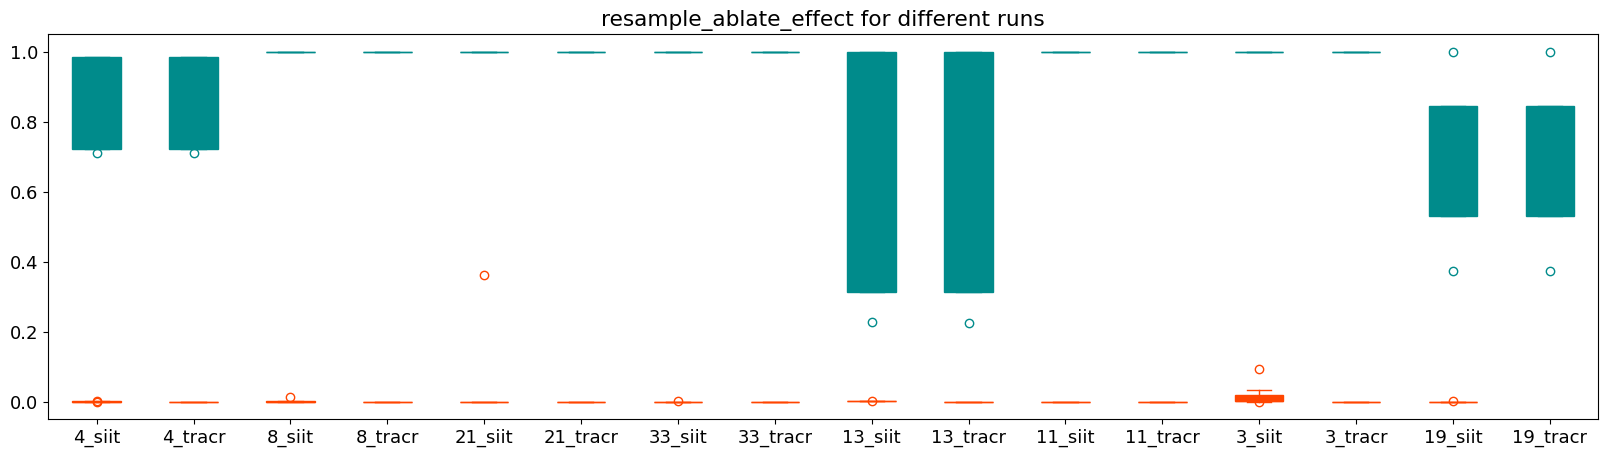

In [17]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
                        key = "resample_ablate_effect",
                        normalize_by_runs=False)

Run 19 does not have not_in_circuit


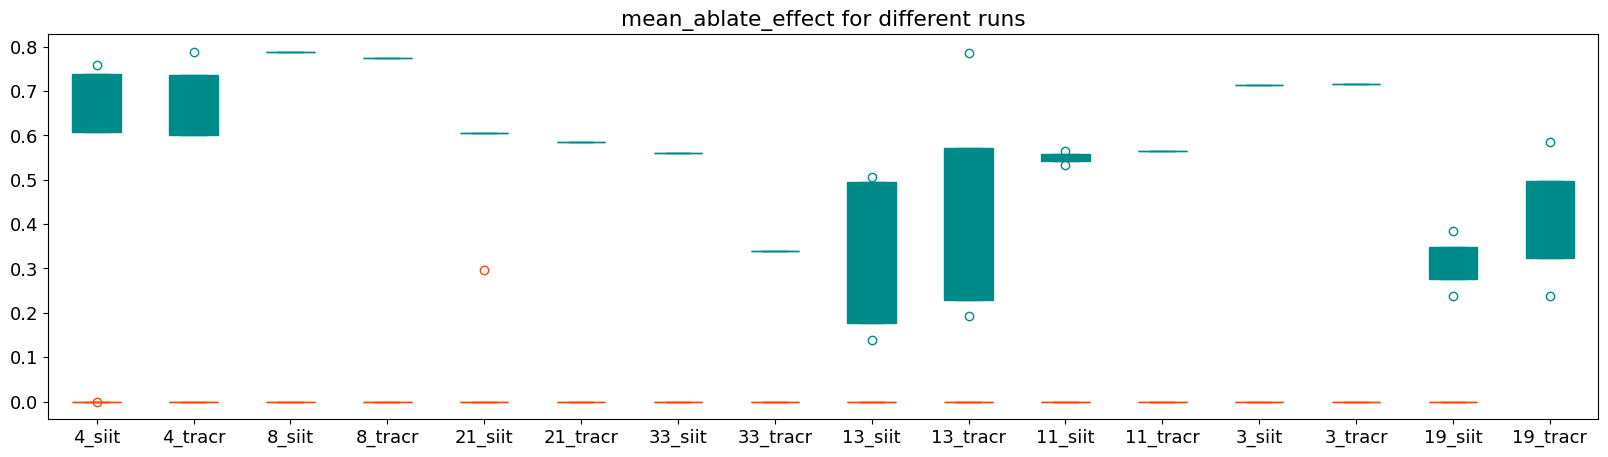

In [18]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             key = "mean_ablate_effect",
             normalize_by_runs=False)

Run 19 does not have not_in_circuit


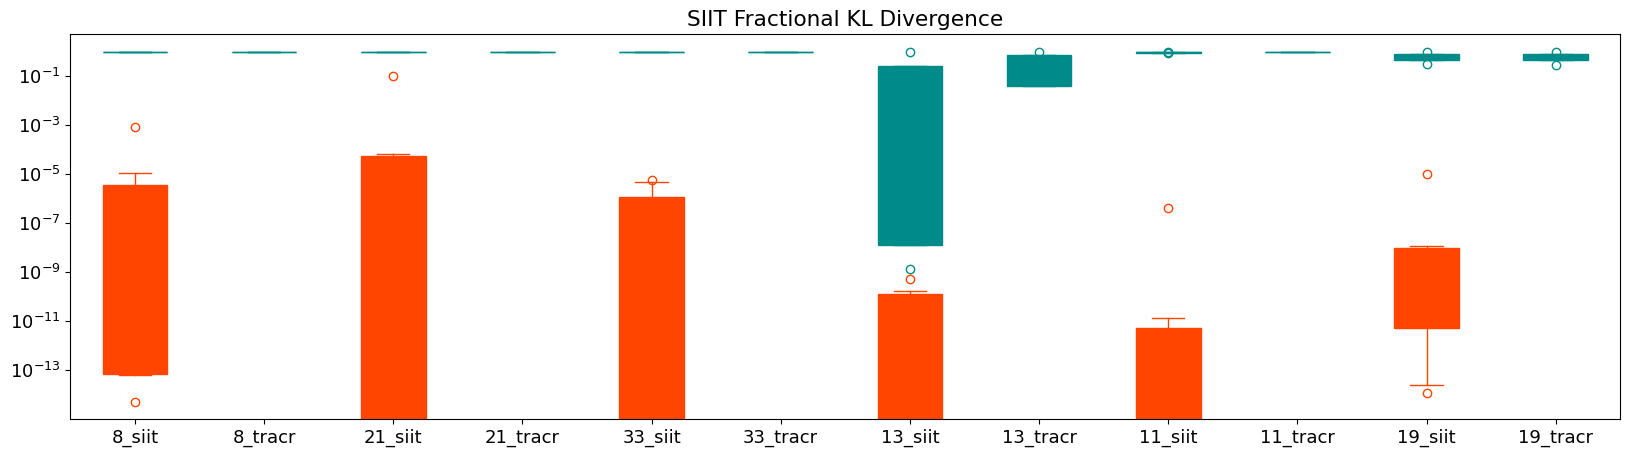

In [19]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr, 
             key = "resample_ablate_effect",
             title="SIIT Fractional KL Divergence",
             normalize_by_runs=True,
             plot_y_log=True)

IIT

In [20]:
import matplotlib.pyplot as plt

def plot_results_in_box_plot(
    df_combined,
    df_combined_tracr,
    df_iit=None,
    key="resample_ablate_effect",
    normalize_by_runs=True,
    figsize=(20, 5),
    plot_y_log=False,
    title=None,
):

    def plot_box(status_list, num_columnns, c, tracr=False, iit=False):
        def get_key(df):
            try:
                return df[key]
            except KeyError:
                return pd.Series()

        pos = 1 if tracr else 2 if iit else 0
        if iit:
            assert df_iit is not None, "df_iit is None, but iit is True"

        positions = (
            range(pos, num_columnns * 2, 2)
            if df_iit is None
            else range(pos, num_columnns * 3, 3)
        )
        plt.boxplot(
            [get_key(df) for df in status_list],
            positions=positions,
            patch_artist=True,
            showfliers=True,
            whis=[5, 95],
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
        )
        # plot y in log scale
        if plot_y_log:
            plt.yscale("log")

    (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        common_runs,
        num_columnns,
    ) = get_circuit_lists(df_combined, df_combined_tracr, key, normalize_by_runs)

    if df_iit is not None:
        (
            in_circuit_list_iit,
            not_in_circuit_list_iit,
            tracr_in_circuit_list_iit,
            tracr_not_in_circuit_list_iit,
            common_runs_iit,
            num_columnns_iit,
        ) = get_circuit_lists(df_iit, df_combined_tracr, key, normalize_by_runs)
        assert (
            common_runs == common_runs_iit
        ), f"Common runs are not the same {common_runs} != {common_runs_iit}"
        assert (
            num_columnns == num_columnns_iit
        ), f"Number of columns are not the same {num_columnns} != {num_columnns_iit}"

    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"{key} for different runs")
    plot_box(in_circuit_list, num_columnns, "darkcyan")
    plot_box(tracr_in_circuit_list, num_columnns, "darkcyan", tracr=True)
    plot_box(not_in_circuit_list, num_columnns, "orangered")
    plot_box(tracr_not_in_circuit_list, num_columnns, "orangered", tracr=True)
    if df_iit is not None:
        plot_box(in_circuit_list_iit, num_columnns, "darkcyan", iit=True)
        plot_box(tracr_in_circuit_list_iit, num_columnns, "orangered", iit=True)

    x_tick_labels = []
    for i, run in enumerate(common_runs):
        x_tick_labels.append(run + "\nSIIT")
        x_tick_labels.append(run + "\nTracr")
        if df_iit is not None:
            x_tick_labels.append(run + "\nIIT")
    if df_iit is not None:
        plt.xticks(
            range(0, num_columnns * 3),
            x_tick_labels,
        )
    else:
        plt.xticks(
            range(0, num_columnns * 2),
            x_tick_labels,
        )


Run 19 does not have not_in_circuit
Run 19 does not have not_in_circuit


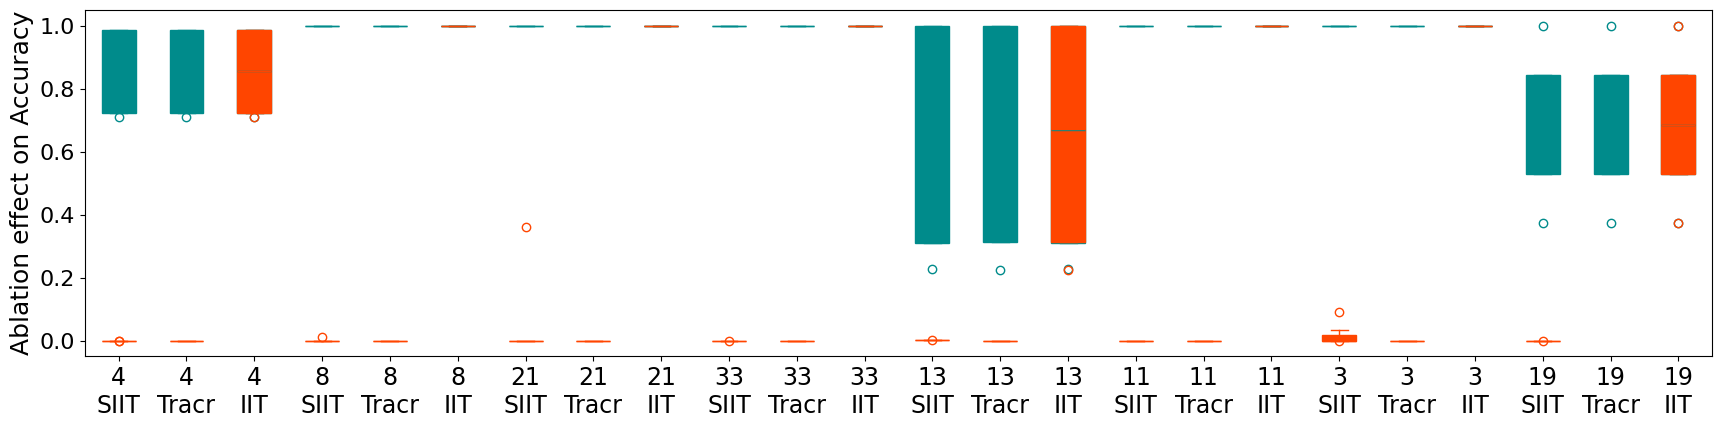

In [21]:
# set font size
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'xtick.labelsize': 17})
plt.rcParams.update({'ytick.labelsize': 16})

plot_results_in_box_plot(df_combined, df_combined_tracr, 
             df_iit=df_combined_iit,
             key = "resample_ablate_effect",
             title = "",
             normalize_by_runs=False, 
             figsize=(21, 4.5))
plt.ylabel("Ablation effect on Accuracy")
# rotate x labels

# plt.xlabel("algorithm_task")

import matplotlib.pyplot as plt
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/box_plot_resample_ablate_effect.pdf', bbox_inches='tight', format='pdf', dpi=600)

Run 19 does not have not_in_circuit
Run 19 does not have not_in_circuit


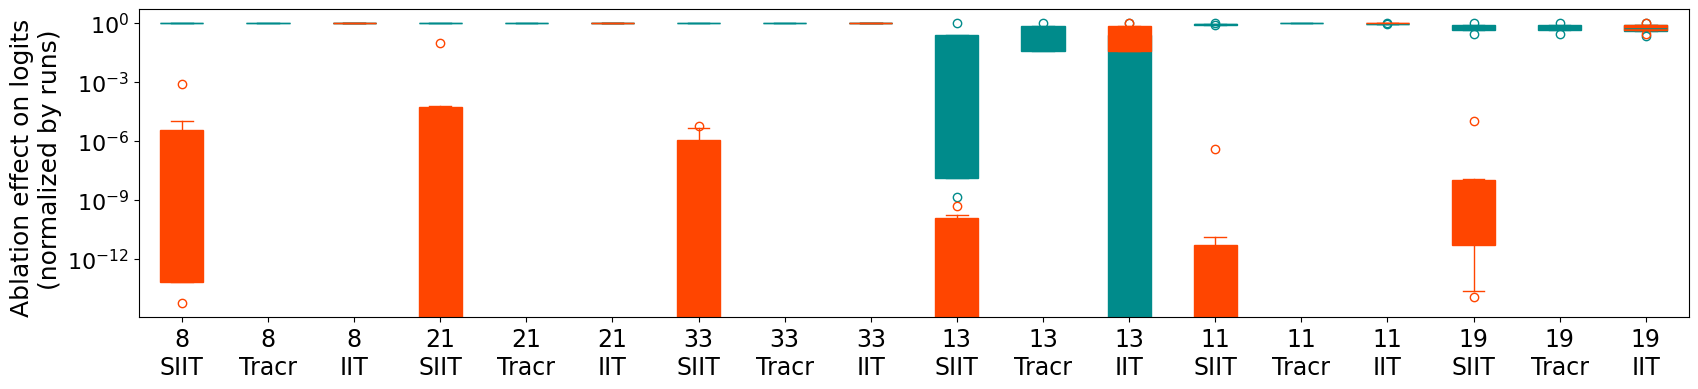

In [22]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr, 
             df_iit=df_combined_kl_iit,
             key = "resample_ablate_effect",
             title = "",
             normalize_by_runs=True, 
             plot_y_log=True,
             figsize=(20, 4))
plt.ylabel("Ablation effect on logits \n (normalized by runs)")

import matplotlib.pyplot as plt
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/box_plot_resample_ablate_effect_kl_div.pdf', bbox_inches='tight', format='pdf', dpi=600)

In [23]:
df_combined_iit.groupby('run').get_group('13')

,node,status,resample_ablate_effect,mean_ablate_effect,run
69,"blocks.0.attn.hook_result, head 2",not_in_circuit,0.001619,0.000000,13
70,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.001619,0.000000,13
71,"blocks.1.attn.hook_result, head 0",not_in_circuit,0.001619,0.000000,13
72,"blocks.1.attn.hook_result, head 1",not_in_circuit,0.001619,0.000000,13
73,"blocks.1.attn.hook_result, head 2",not_in_circuit,0.001619,0.000000,13
74,"blocks.1.attn.hook_result, head 3",not_in_circuit,0.001836,0.000000,13
75,blocks.0.mlp.hook_post,in_circuit,0.998870,0.442026,13
76,"blocks.0.attn.hook_result, head 1",in_circuit,0.339662,0.197397,13
77,blocks.1.mlp.hook_post,in_circuit,0.998870,0.470137,13
78,"blocks.0.attn.hook_result, head 0",in_circuit,0.227378,0.139590,13


In [24]:
# plot_results_in_box_plot(df_combined, df_combined_tracr,
#              df_iit=df_combined_iit,
#              key = "mean_ablate_effect",
#              title = "Mean ablate node effect",
#              normalize_by_runs=False,
#              figsize=(40, 10))

In [25]:
# plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr,
#              df_iit=df_combined_kl_iit,
#              key = "resample_ablate_effect",
#              title="Fractional KL Divergence",
#              normalize_by_runs=True,
#             plot_y_log=True,
#             figsize=(40, 10))

### Scatter

In [26]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="SIIT vs TRACR resample ablate effect",
#                 mean=True)

Run 19 does not have not_in_circuit
[0.8516066534586193, 1.0, 1.0, 0.9999999999999368, 0.6416721029783914, 1.0, 0.9999999999999996, 0.6863983346434651] [0.8516066534586177, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.6411948583822882, 0.9999999999999368, 0.9999999999999996, 0.6863983346434651] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan] [0.03772272161409055, 0.1111111111111041, 0.22456332161373846, 0.1111111380419603, 0.0016550457713428333, 0.12748049682176954, 0.21787919960393928, 0.16413821836473394]
8 8


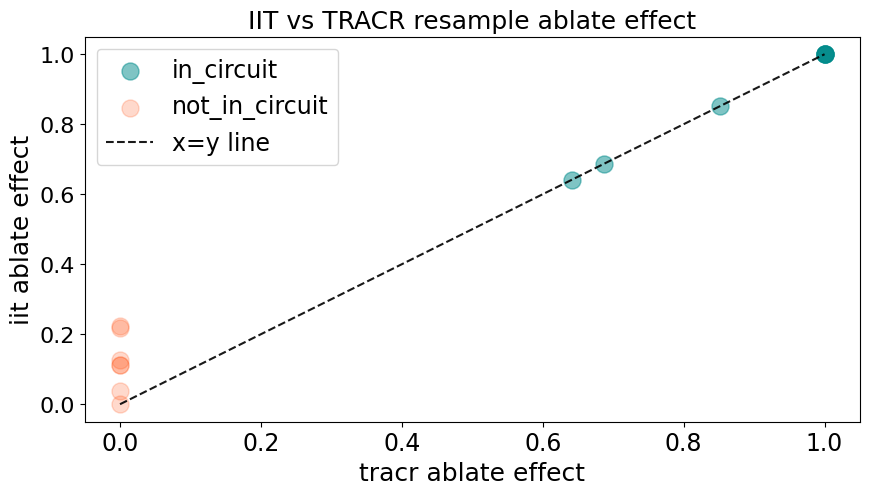

In [27]:
plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs TRACR resample ablate effect",
                mean=True)

In [28]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="SIIT vs TRACR resample ablate effect",
#                 mean=False)

In [29]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="IIT vs TRACR resample ablate effect",
#                 mean=False)

[0.8516066534586177, 1.0, 1.0, 0.9999999999999368, 0.6411932363790154, 1.0, 0.9999999999999996, 0.6863988540600106] [0.8516066534586177, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.6411948583822882, 0.9999999999999368, 0.9999999999999996, 0.6863983346434651] [2.6801570337615134e-05, 0.0014946442620427222, 0.040091275763517356, 4.916071865867041e-06, 0.0016189334366709669, 0.0, 0.018761492901234945, 7.72731635602546e-06] [0.03772272161409055, 0.1111111111111041, 0.22456332161373846, 0.1111111380419603, 0.0016550457713428333, 0.12748049682176954, 0.21787919960393928, 0.16413821836473394]
8 8


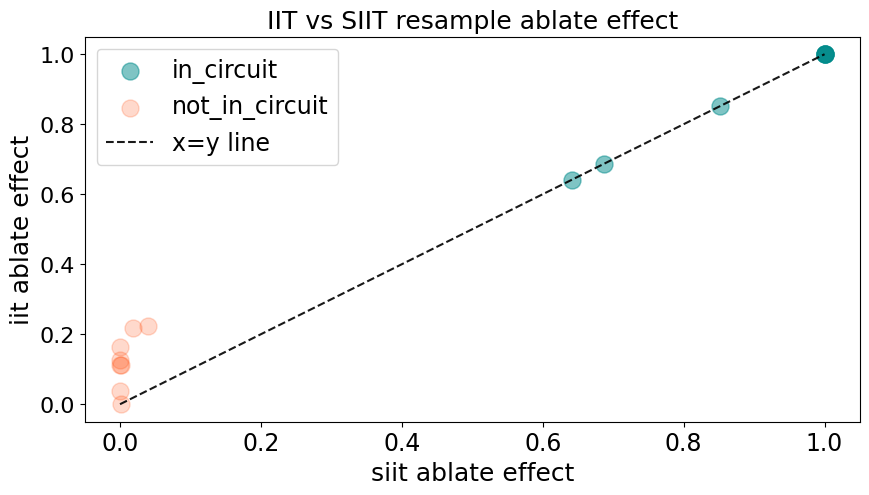

In [30]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=True,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)

plt.savefig('plots/scatter_plot_resample_ablate_effect.pdf', bbox_inches='tight', format='pdf', dpi=600)

[0.9851929165418152, 0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 1.0, 1.0, 0.9999999999999368, 0.227374332949931, 0.9988696693473456, 0.3396592738714397, 0.9988696693473456, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368, 0.3727977081200843] [0.9851929165418152, 0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.2273776607403042, 0.998869669347339, 0.3396624340941708, 0.998869669347339, 0.9999999999999368, 0.9999999999999368, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368, 0.3727966692869934] [0.0001005847152068, 4.029317045345512e-06, 0.0, 8.521608668395309e-07, 4.177998205315348e-06, 5.11652307013904e-05, 0.0, 1.6526879073005065e-06, 0.000135657165834, 0.0, 0.0, 0.0002556910299634, 0.0, 0.0130587974746798, 0.0, 0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.424464679280337e-05, 0.0016188418601002, 0.00161884186

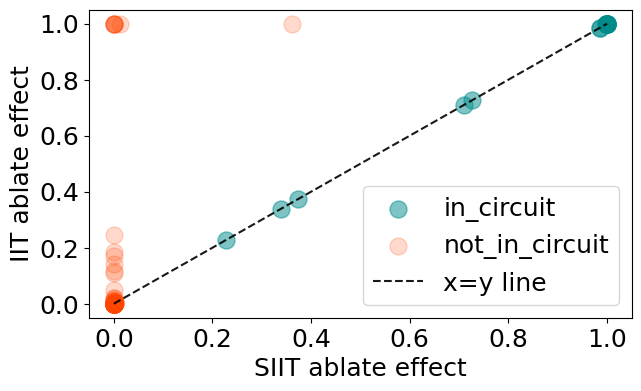

In [53]:

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'xtick.labelsize': 18})
plt.rcParams.update({'ytick.labelsize': 18})
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="",
                mean=False,
                figsize=(7, 4),
                xlabel="SIIT ablate effect",
                ylabel="IIT ablate effect",
                both_iit=True)
# figsize=(4, 4)
plt.savefig('plots/scatter_plot_resample_ablate_effect_all_nodes.pdf', bbox_inches='tight', format='pdf', dpi=600)

In [32]:
# (df_combined[df_combined["resample_ablate_effect"] > 0.4]).groupby('status').get_group('not_in_circuit')

[0.6080670553887094, 0.7313269258647798, 0.7578692452278089, 0.6080670553887094, 0.7875942884775373, 0.6048019932920792, 0.560727900995469, 0.1394250593198373, 0.5065148146029353, 0.1886863186922682, 0.4915761480789915, 0.564688846756477, 0.5343042831910604, 0.7140624994421386, 0.7140624994421386, 0.3854062765405733, 0.2388297900059099] [0.6080670553887094, 0.7563249277731646, 0.7191887784910239, 0.6080670553887094, 0.4369471305835358, 0.6001028716528128, 0.2451316734974423, 0.139590289966043, 0.4701367945569152, 0.1973973978457066, 0.4420261601843501, 0.7869962832598858, 0.7869962832598858, 0.7999999993749999, 0.7140624994421386, 0.3854062765405733, 0.2375227780710419] [0.0, 0.0, 0.0, 0.0, 6.993286442281035e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2974811421221364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

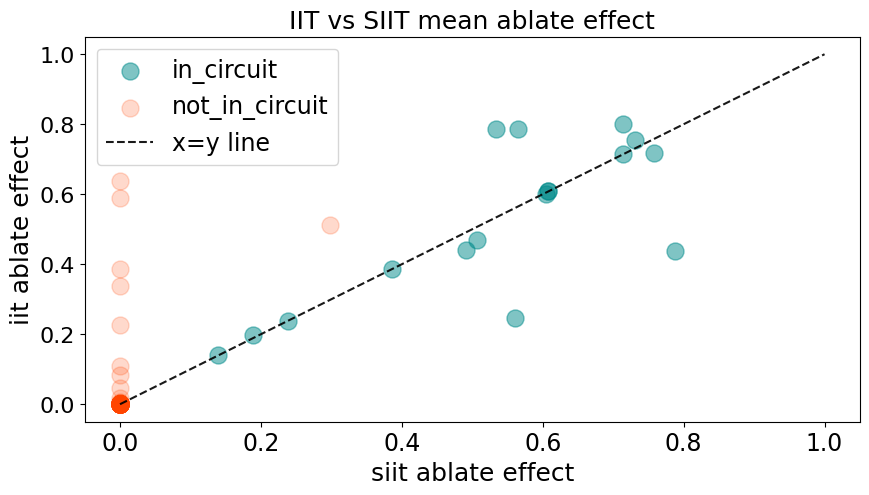

In [33]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "mean_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT mean ablate effect",
                mean=False,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)

plt.savefig('plots/scatter_plot_mean_ablate_effect_all_nodes.pdf', bbox_inches='tight', format='pdf', dpi=600)

[0.9851929165418152, 0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 1.0, 1.0, 0.9999999999999368, 0.227374332949931, 0.9988696693473456, 0.3396592738714397, 0.9988696693473456, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368, 0.3727977081200843] [0.9851929165418152, 0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.2273776607403042, 0.998869669347339, 0.3396624340941708, 0.998869669347339, 0.9999999999999368, 0.9999999999999368, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368, 0.3727966692869934] [0.0001005847152068, 4.029317045345512e-06, 0.0, 8.521608668395309e-07, 4.177998205315348e-06, 5.11652307013904e-05, 0.0, 1.6526879073005065e-06, 0.000135657165834, 0.0, 0.0, 0.0002556910299634, 0.0, 0.0130587974746798, 0.0, 0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.424464679280337e-05, 0.0016188418601002, 0.00161884186

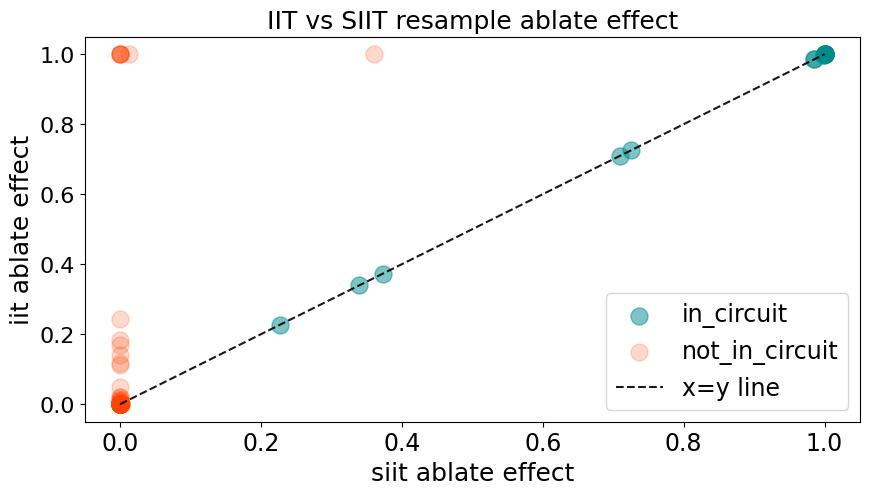

In [34]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=False,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)


### Other Plots

Run 19 does not have not_in_circuit
[0.7101729559026297, 0.7258678248482078, 0.9851929165418198, 0.9851929165418198, 1.0, 0.9999999999999368, 1.0, 0.3412660180679928, 0.2254223938455726, 1.0, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996, 0.3727966692869934, 0.9999999999999368] [0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 0.9851929165418152, 1.0, 0.9999999999999368, 0.9988696693473456, 0.3396592738714397, 0.227374332949931, 0.9988696693473456, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996, 0.3727977081200843, 0.9999999999999368] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0.0001005847152068, 4.029317045345512e-06, 0.0, 8.521608668395309e-07, 4.177998205315348e-06, 5.11652307013904e-05, 0.0, 1.6526879073005065e-06, 0.000135657165834, 0.0, 0.0, 0.0002556910299634, 0.0, 0.0130587974746798, 0.0, 0.0, 0.0, 0.0, 0.36082148187165

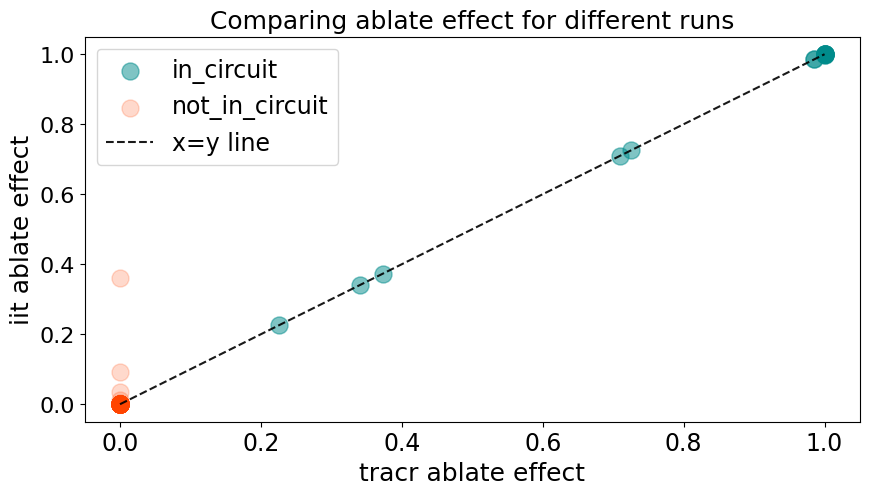

In [35]:
plot_results_in_scatter_plot(df_combined, df_combined_tracr,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=False)

In [36]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "mean_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 mean=False)

Run 19 does not have not_in_circuit
[1.0, 1.0, 1.0, 0.03812599850187552, 0.03812599850187552, 0.6730572688026196, 1.0, 1.0, 0.29392560745417473, 1.0] [0.9655669301904908, 0.8666413969276213, 0.1825204811773973, 2.1602768053874475, 7.178811202298084, 133108287.1255133, 0.9684055412381548, 0.8153269039234751, 0.2847359389347114, 0.96322236918314] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1.1333798631960354e-11, 5.1748382872663175e-08, 3.511295693854468e-06, 2.3594149373859053e-13, 6.177697672581319e-14, 1.0721633157274882e-05, 5.18140001079079e-15, 0.0008365084193811949, 6.698308257957872e-14, 5.497553355723648e-07, 2.1994710133983592e-06, 4.937992464971909e-06, 0.10491792706847157, -1.2756539514192559e-05, -3.796997711865473e-06, -1.8504554681272272e-05, 6.266470367215383e-05, 5.5558695653531333e-05, 0.0, 0.0, 0.0, 0.0, 6.75133979178287e-08, 5.861655397012184e-06, 4.597126705415884

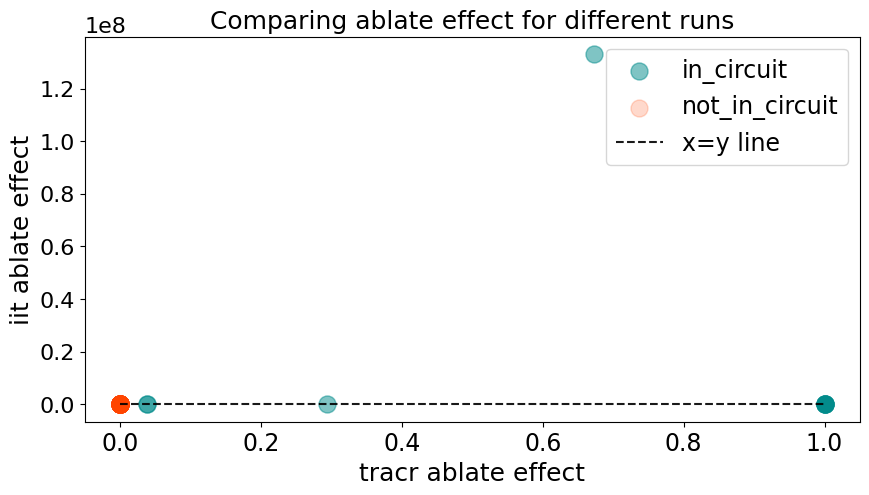

In [37]:
plot_results_in_scatter_plot(df_combined_kl, df_combined_kl_tracr,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=False,
                mean=False)

Run 19 does not have not_in_circuit
[1.0, 1.0, 1.0, 0.43732731645159273, 1.0, 0.6469628037270874] [1.0, 1.0, 1.0, 0.25000007706438926, 0.9932060965888019, 0.6166215435441484] [-0.0013136612860038671, 0.0, 0.0, 0.0, 0.0, nan] [0.09440940526617608, 0.1898786585641309, 0.09194832685687832, 7.301964166654053e-08, 0.09429373393923804, 0.11887276865242824]
6 6


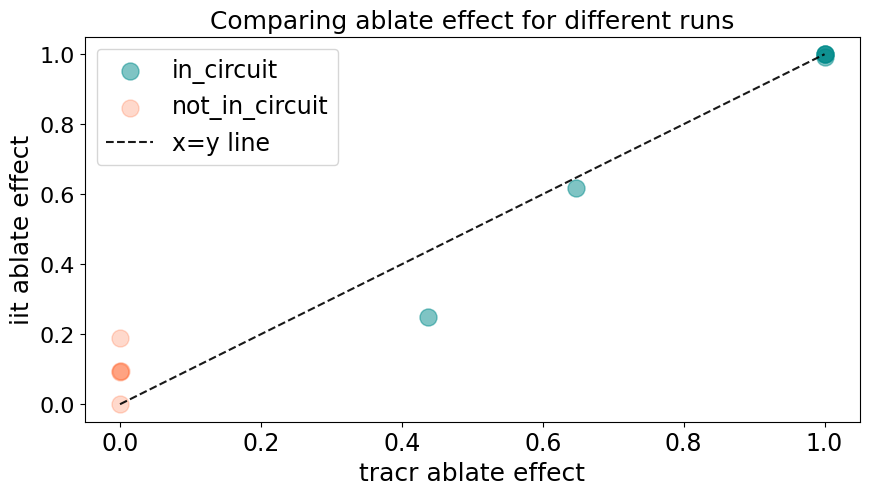

In [38]:
plot_results_in_scatter_plot(df_combined_kl_iit, df_combined_kl_tracr_iit,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=False,
                mean=True)

### Summary of Boxplots

In [19]:
from utils.get_circuit_discovery_scores import append_row

def get_circuit_list_by_status(df_: pd.DataFrame) -> tuple[list, list]:
    df = df_.copy()
    in_circuit_list = [run_df[run_df["status"] == "in_circuit"] for run, run_df in df.groupby("run")]
    not_in_circuit_list = [run_df[run_df["status"] == "not_in_circuit"] for run, run_df in df.groupby("run")]
    return in_circuit_list, not_in_circuit_list

def make_summary(in_circuit_list, not_in_circuit_list, key = "resample_ablate_effect"):
    summaries = pd.DataFrame(columns=['run', 'strict weight', 'quartiles (in circuit)', 'range (in circuit)', 'quartiles (not in circuit)', 'range (not in circuit)'])
    for i in range(len(in_circuit_list)):
        entry = {}
        entry['run'] = in_circuit_list[i]['run'].unique()[0]
        entry['strict weight'] = get_best_weight(entry['run'], individual=True)["strict"]
        quartiles = in_circuit_list[i][key].quantile([0.25, 0.75])
        median = in_circuit_list[i][key].median()
        entry['quartiles (in circuit)'] = f"{quartiles[0.25]:.2f} - {median:.2f} - {quartiles[0.75]:.2f}"
        entry['range (in circuit)'] = f"{in_circuit_list[i][key].min():.2f} - {in_circuit_list[i][key].max():.2f}"
        quartiles = not_in_circuit_list[i][key].quantile([0.25, 0.75])
        median = not_in_circuit_list[i][key].median()
        entry['quartiles (not in circuit)'] = f"{quartiles[0.25]:.2f} - {median:.2f} - {quartiles[0.75]:.2f}"
        entry['range (not in circuit)'] = f"{not_in_circuit_list[i][key].min():.2f} - {not_in_circuit_list[i]['resample_ablate_effect'].max():.2f}"
        summaries = append_row(summaries, pd.Series(entry))
    # start index from 1
    summaries.index = summaries.index + 1
    return summaries

in_circuit_list, not_in_circuit_list = get_circuit_list_by_status(df_combined)
summary = make_summary(in_circuit_list, not_in_circuit_list)
summary.to_csv('plots/summary_resample.csv', index=False)
summary


/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


,run,strict weight,quartiles (in circuit),range (in circuit),quartiles (not in circuit),range (not in circuit)
1,11,0.4,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00
2,13,0.4,0.31 - 0.67 - 1.00,0.23 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00
3,18,1.0,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.01
4,19,0.4,0.53 - 0.69 - 0.84,0.37 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00
5,20,0.4,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00
6,21,0.5,0.13 - 0.14 - 0.36,0.13 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.04
7,26,0.4,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00
8,29,0.4,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00
9,3,10.0,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.02,0.00 - 0.09
10,33,0.4,1.00 - 1.00 - 1.00,1.00 - 1.00,0.00 - 0.00 - 0.00,0.00 - 0.00


18, 21, 34-37

10 * iit + 100 * b + 1000 * s
10 s, 1 iit, 1 b

1. Maybe it needs more dimensions
2. Multiple steps for Strict loss

In [20]:
# in_circuit_list, not_in_circuit_list = get_circuit_list_by_status(df_combined_tracr)
summary_mean = make_summary(in_circuit_list, not_in_circuit_list, key = 'mean_ablate_effect')
summary_mean.to_csv('plots/summary_mean.csv', index=False)
summary_mean

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


,run,strict weight,quartiles (in circuit),range (in circuit),quartiles (not in circuit),range (not in circuit)
1,11,0.4,0.54 - 0.55 - 0.56,0.53 - 0.56,0.00 - 0.00 - 0.00,0.00 - 0.00
2,13,0.4,0.18 - 0.34 - 0.50,0.14 - 0.51,0.00 - 0.00 - 0.00,0.00 - 0.00
3,18,1.0,0.45 - 0.46 - 0.46,0.45 - 0.47,0.00 - 0.00 - 0.00,0.00 - 0.01
4,19,0.4,0.27 - 0.31 - 0.35,0.24 - 0.39,0.00 - 0.00 - 0.00,0.00 - 0.00
5,20,0.4,0.22 - 0.22 - 0.22,0.22 - 0.22,0.00 - 0.00 - 0.00,0.00 - 0.00
6,21,0.5,0.13 - 0.14 - 0.19,0.11 - 0.31,0.00 - 0.00 - 0.00,0.00 - 0.04
7,26,0.4,0.57 - 0.57 - 0.57,0.57 - 0.57,0.00 - 0.00 - 0.00,0.00 - 0.00
8,29,0.4,0.79 - 0.79 - 0.79,0.79 - 0.79,0.00 - 0.00 - 0.00,0.00 - 0.00
9,3,10.0,0.71 - 0.71 - 0.71,0.71 - 0.71,0.00 - 0.00 - 0.00,0.00 - 0.09
10,33,0.4,0.56 - 0.56 - 0.56,0.56 - 0.56,0.00 - 0.00 - 0.00,0.00 - 0.00
